In [11]:
import pandas as pd
import numpy as np

# Load the CSV file
file_path = r'D:\FABIZ\AI\train.csv'
df = pd.read_csv(file_path)

# Handle missing values
# Drop rows where essential columns have missing values (e.g., 'Name', 'City', 'State')
df.dropna(subset=['Name', 'City', 'State', 'Bank', 'ApprovalDate'], inplace=True)

# Fill missing values in numeric columns with 0 or a specified value
numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns] = df[numeric_columns].fillna(0)

# Convert data types
# Convert date columns to datetime
df['ApprovalDate'] = pd.to_datetime(df['ApprovalDate'], format='%d-%b-%y', errors='coerce')
df['ChgOffDate'] = pd.to_datetime(df['ChgOffDate'], format='%d-%b-%y', errors='coerce')
df['DisbursementDate'] = pd.to_datetime(df['DisbursementDate'], format='%d-%b-%y', errors='coerce')

# Clean monetary columns by removing dollar signs and commas, then converting to float
df['DisbursementGross'] = df['DisbursementGross'].replace('[\\$,]', '', regex=True).astype(float)
df['BalanceGross'] = df['BalanceGross'].replace('[\\$,]', '', regex=True).astype(float)

# Clean string columns by trimming whitespace
string_columns = df.select_dtypes(include=[object]).columns
df[string_columns] = df[string_columns].apply(lambda col: col.str.strip() if col.dtype == 'object' else col)

# Handle duplicate rows
df.drop_duplicates(inplace=True)

# Transform specific columns
# Ensure 'RevLineCr' and 'LowDoc' are consistently formatted as 'Y' or 'N'
df['RevLineCr'] = df['RevLineCr'].apply(lambda x: 'Y' if x == 'Yes' else ('N' if x == 'No' else x))
df['LowDoc'] = df['LowDoc'].apply(lambda x: 'Y' if x == 'Yes' else ('N' if x == 'No' else x))

# Display the shape of the cleaned dataframe
print("DataFrame shape:", df.shape)

# Save the cleaned dataframe to a new CSV file
cleaned_file_path = r'D:\FABIZ\AI\cleaned_train.csv'
df.to_csv(cleaned_file_path, index=False)

print(f"Cleaned data saved to {cleaned_file_path}")


DataFrame shape: (49119, 22)
Cleaned data saved to D:\FABIZ\AI\cleaned_train.csv


In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# Load the datasets
train_df = pd.read_csv(r'D:\FABIZ\AI\cleaned_train.csv')
test_df = pd.read_csv(r'D:\FABIZ\AI\test_nolabel.csv')
sample_submission_df = pd.read_csv(r'D:\FABIZ\AI\sample_submission.csv')

# Define the target and features
X = train_df.drop(columns=['id', 'Accept'])
y = train_df['Accept']

# Preprocess the data
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Define preprocessing steps for numeric features
numeric_transformer = Pipeline(steps=[
    ('convert_to_numeric', FunctionTransformer(lambda x: x.replace(r'[\$,]', '', regex=True).astype(float))),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define preprocessing steps for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Preprocess the training data
X_preprocessed = preprocessor.fit_transform(X)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Build the neural network model
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

# Preprocess the test data
X_test = test_df.drop(columns=['id'])
X_test_preprocessed = preprocessor.transform(X_test)

# Make predictions
predictions = model.predict(X_test_preprocessed)
test_df['Accept'] = (predictions > 0.5).astype(int)

# Prepare the submission file
submission_df = test_df[['id', 'Accept']]
submission_df.to_csv(r'D:\FABIZ\AI\submission.csv', index=False)

print("Predictions saved to submission.csv")


Epoch 1/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.9442 - loss: 0.1529 - val_accuracy: 0.9935 - val_loss: 0.0315
Epoch 2/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - accuracy: 0.9955 - loss: 0.0142 - val_accuracy: 0.9889 - val_loss: 0.0420
Epoch 3/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - accuracy: 0.9990 - loss: 0.0034 - val_accuracy: 0.9872 - val_loss: 0.0562
Epoch 4/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - accuracy: 0.9995 - loss: 0.0031 - val_accuracy: 0.9872 - val_loss: 0.0627
Epoch 5/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - accuracy: 1.0000 - loss: 2.7893e-04 - val_accuracy: 0.9895 - val_loss: 0.0641
Epoch 6/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.9997 - loss: 0.0014 - val_accuracy: 0.9902 - val_loss: 0.0677
Epoch 7/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - accuracy: 1.0000 - loss: 4.6980e-05 - val_accuracy: 0.9883 - val_loss: 0.0741
Epoch 8/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - accuracy: 

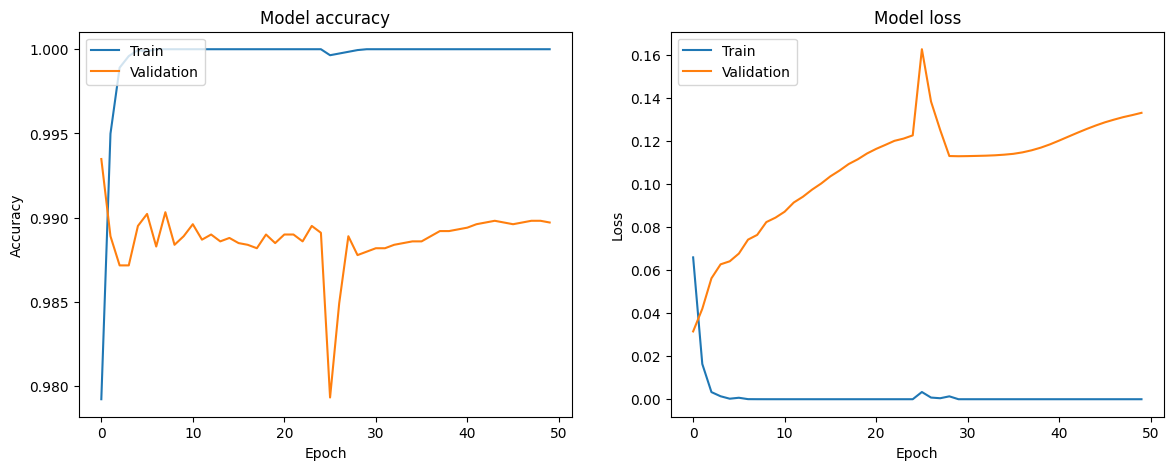

In [33]:
import matplotlib.pyplot as plt

# Assume 'history' is the output of the model.fit() method
# history = model.fit(...)

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


Epoch 1/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.8942 - loss: 0.2949 - val_accuracy: 0.9934 - val_loss: 0.0552
Epoch 2/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.9923 - loss: 0.0756 - val_accuracy: 0.9935 - val_loss: 0.0507
Epoch 3/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.9933 - loss: 0.0652 - val_accuracy: 0.9934 - val_loss: 0.0496
Epoch 4/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.9927 - loss: 0.0584 - val_accuracy: 0.9934 - val_loss: 0.0495
Epoch 5/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.9927 - loss: 0.0574 - val_accuracy: 0.9934 - val_loss: 0.0495
Epoch 6/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.9931 - loss: 0.0544 - val_accuracy: 0.9934 - val_loss: 0.0487
Epoch 7/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.9930 - loss: 0.0532 - val_accuracy: 0.9934 - val_loss: 0.0505
Epoch 8/50
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.9924 -

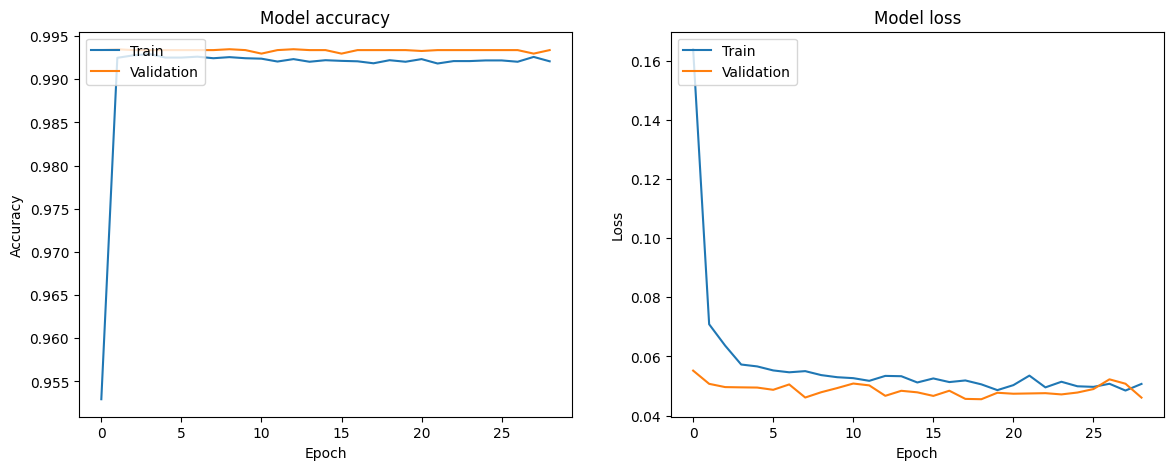

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Predictions saved to submission.csv


In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the datasets
train_df = pd.read_csv(r'D:\FABIZ\AI\cleaned_train.csv')
test_df = pd.read_csv(r'D:\FABIZ\AI\test_nolabel.csv')
sample_submission_df = pd.read_csv(r'D:\FABIZ\AI\sample_submission.csv')

# Define the target and features
X = train_df.drop(columns=['id', 'Accept'])
y = train_df['Accept']

# Preprocess the data
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('convert_to_numeric', FunctionTransformer(lambda x: x.replace(r'[\$,]', '', regex=True).astype(float))),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Preprocess the training data
X_preprocessed = preprocessor.fit_transform(X)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Build the neural network model
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Preprocess the test data
X_test = test_df.drop(columns=['id'])
X_test_preprocessed = preprocessor.transform(X_test)

# Make predictions
predictions = model.predict(X_test_preprocessed)
test_df['Accept'] = (predictions > 0.5).astype(int)

# Prepare the submission file
submission_df = test_df[['id', 'Accept']]
submission_df.to_csv(r'D:\FABIZ\AI\submission.csv', index=False)

print("Predictions saved to submission.csv")
